<a href="https://colab.research.google.com/github/Jezzej/ml-mlops/blob/main/energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving pjmhorly.csv to pjmhorly.csv


{'pjmhorly.csv': b'Datetime,PJME_MW\r\n12/31/2002 1:00,26498\r\n12/31/2002 2:00,25147\r\n12/31/2002 3:00,24574\r\n12/31/2002 4:00,24393\r\n12/31/2002 5:00,24860\r\n12/31/2002 6:00,26222\r\n12/31/2002 7:00,28702\r\n12/31/2002 8:00,30698\r\n12/31/2002 9:00,31800\r\n12/31/2002 10:00,32359\r\n12/31/2002 11:00,32371\r\n12/31/2002 12:00,31902\r\n12/31/2002 13:00,31126\r\n12/31/2002 14:00,30368\r\n12/31/2002 15:00,29564\r\n12/31/2002 16:00,29098\r\n12/31/2002 17:00,30308\r\n12/31/2002 18:00,34017\r\n12/31/2002 19:00,34195\r\n12/31/2002 20:00,32790\r\n12/31/2002 21:00,31336\r\n12/31/2002 22:00,29887\r\n12/31/2002 23:00,28483\r\n1/1/2003 0:00,27008\r\n12/30/2002 1:00,27526\r\n12/30/2002 2:00,26600\r\n12/30/2002 3:00,26241\r\n12/30/2002 4:00,26213\r\n12/30/2002 5:00,26871\r\n12/30/2002 6:00,28679\r\n12/30/2002 7:00,31509\r\n12/30/2002 8:00,33665\r\n12/30/2002 9:00,34625\r\n12/30/2002 10:00,34655\r\n12/30/2002 11:00,34295\r\n12/30/2002 12:00,33711\r\n12/30/2002 13:00,33087\r\n12/30/2002 14:00,326

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

df = pd.read_csv("pjmhorly.csv")


performing eda on the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Datetime  145366 non-null  object
 1   PJME_MW   145366 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


In [7]:
df = df.set_index('Datetime')

In [8]:
color = sns.color_palette()

<Axes: title={'center': 'PJME_HOURLY'}, xlabel='Datetime'>

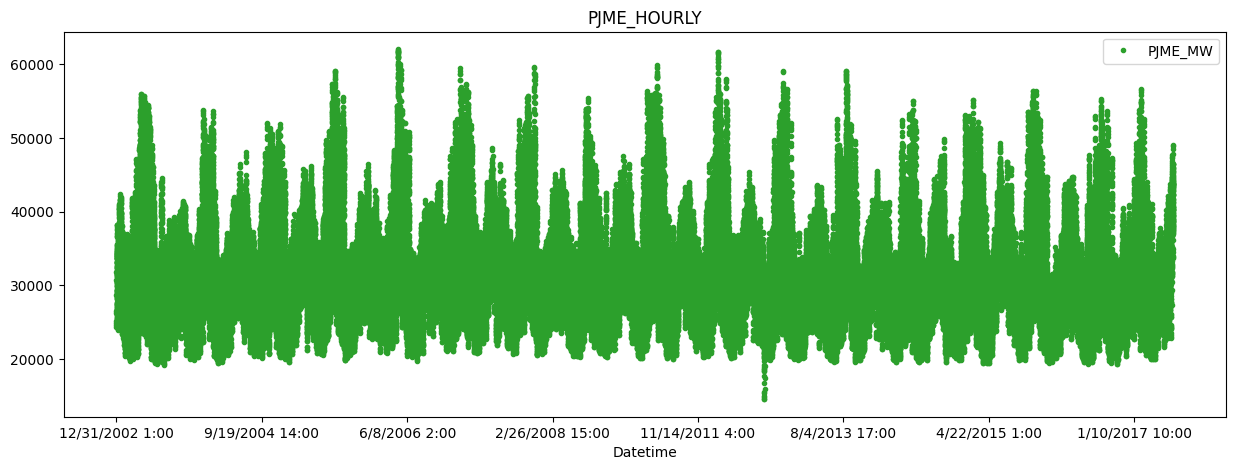

In [9]:
df.plot(style = '.', figsize = (15,5), color = color[2], title = 'PJME_HOURLY')

In [10]:
df.index = pd.to_datetime(df.index)


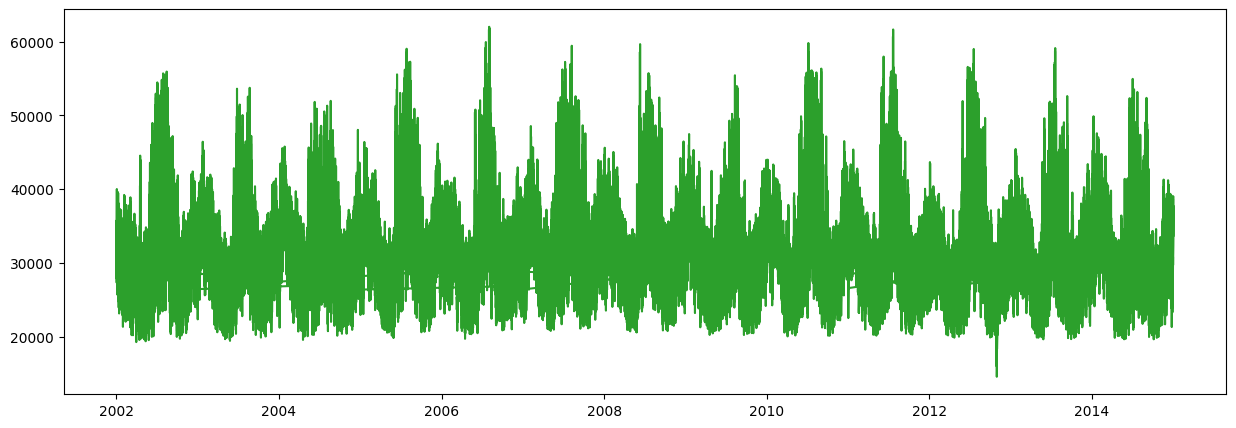

In [11]:
new = df[df.index < '1/1/2015']
plt.figure(figsize = (15,5))
plt.plot(new.index, new.values, '-', color = color[2])
plt.show()


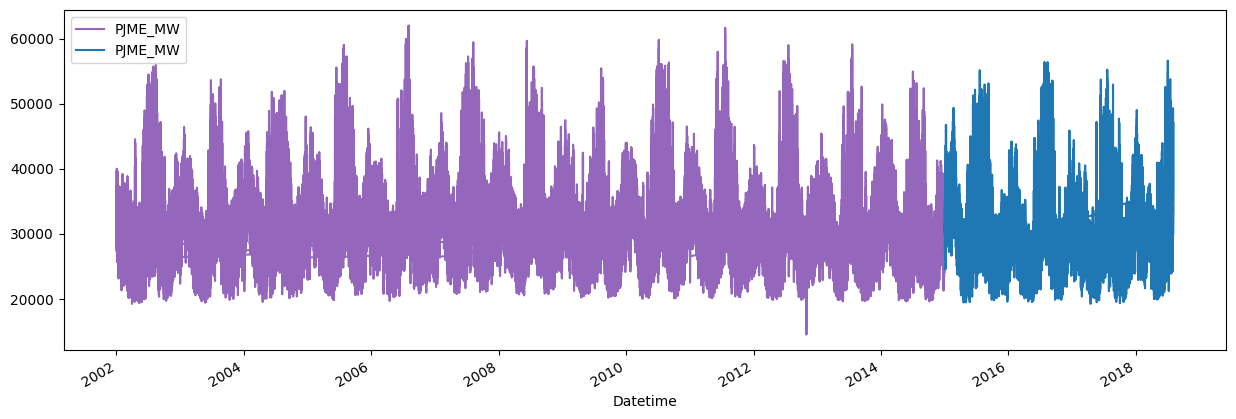

In [12]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, color = color[4], label='train')
test.plot( ax = ax, label='test')
plt.show()

In [13]:
f"from {df.index.max()} to {df.index.min()}"

'from 2018-08-03 00:00:00 to 2002-01-01 01:00:00'

In [15]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [16]:
"""df_PJME_datetime = df.reset_index()
print("Datetime Describe:")
print(f"{df_PJME_datetime['Datetime'].describe()}\n")

print("Check of Duplicates (Datetimes):")
print(f"{df[df.index.duplicated()]}\n")

print("Missing Dates:")
missing_dates = pd.date_range(start=pd.to_datetime('2002-01-01 01:00:00'), end=pd.to_datetime('2018-08-03 00:00:00'), freq='h').difference(df.index)
print(f"Missing Dates: {len(missing_dates)}")
print(missing_dates)"""

'df_PJME_datetime = df.reset_index()\nprint("Datetime Describe:")\nprint(f"{df_PJME_datetime[\'Datetime\'].describe()}\n")\n\nprint("Check of Duplicates (Datetimes):")\nprint(f"{df[df.index.duplicated()]}\n")\n\nprint("Missing Dates:")\nmissing_dates = pd.date_range(start=pd.to_datetime(\'2002-01-01 01:00:00\'), end=pd.to_datetime(\'2018-08-03 00:00:00\'), freq=\'h\').difference(df.index)\nprint(f"Missing Dates: {len(missing_dates)}")\nprint(missing_dates)'

In [17]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498
2002-12-31 02:00:00,25147
2002-12-31 03:00:00,24574
2002-12-31 04:00:00,24393
2002-12-31 05:00:00,24860


In [18]:
df.isnull().sum()

,0
PJME_MW,0


In [19]:
df.duplicated().sum()

np.int64(116925)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, kstest, skew, kurtosis
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

In [21]:
df['datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('datetime', inplace=True)
df.drop('Datetime', axis=1, inplace=True)


KeyError: 'Datetime'

In [ ]:
df.head(10)

In [ ]:
df.index.is_monotonic_increasing

In [ ]:
df[df.index.duplicated()]

In [ ]:
df['date'] = df.index.date
df['time'] = df.index.time
df.reset_index(drop=True, inplace=True)

In [ ]:
df.tail(10)

In [ ]:
df = df.set_index('date')

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:

print(f'date time describe \n {df["date"].describe()}')

In [ ]:

print(f'date time describe \n {df["time"].describe()}')

In [ ]:
print(f'{df.index.duplicated()}')

In [ ]:
missing = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h').difference(df.index)
print(f'missing dates: {len(missing)}')
print(missing)

In [ ]:
df.head()

In [ ]:
df.sort_index()

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df.drop('index', axis=1, inplace=True)

In [ ]:
df.drop('level_0', axis=1, inplace=True)

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
print(df.isnull().sum())

In [ ]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df = df.set_index('datetime').sort_index()  # Set datetime as index
df.drop(columns=['date', 'time'], inplace=True)  # Drop redundant columns
